### Gaussian Naive Bayes (GNB)

In [6]:
import pandas as pd
import numpy as np
import sys
import time
from datetime import datetime

from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
)
import matplotlib.pyplot as plt
import seaborn as sns

from preprocessing import prepare_data

random_state = 42
results = []
partial_save_path = "results/naive_bayes_partial.csv"

### 1. Load Data

In [7]:
train_df = pd.read_csv("fraudTrain.csv")
test_df = pd.read_csv("fraudTest.csv")

### 2. Prepare Data for LINEAR Models

In [8]:
print("Fitting encoders and scalers on train data...")
out_train_init = prepare_data(
    train_df,
    mode="linear",
    training=False,
    fit=True,
)
encoders = out_train_init["encoders"]
scalers = out_train_init["scalers"]
print("Fit complete.")


print("Preparing test set...")
out_test = prepare_data(
    test_df,
    mode="linear",
    training=False,
    fit=False,
    encoders=encoders,
    scalers=scalers,
)
df_test = out_test["df"]
X_test = df_test.drop("is_fraud", axis=1)
y_test = df_test["is_fraud"]

X_test = X_test.replace([np.inf, -np.inf], np.nan).fillna(0).clip(-1e6, 1e6)

print(f"Test set prepared for linear models. Shape: {X_test.shape}")

Fitting encoders and scalers on train data...
Fit complete.
Preparing test set...
Test set prepared for linear models. Shape: (555719, 25)


### 3. Define Experiment Parameters

In [11]:
ratios_to_test = [None, 0.05, 0.1, 0.2, 0.3, 0.5, 1.0] 
resample_types_to_test = ["df_up", "df_down"] 

param = {
    "name": "GaussianNB",
    "params": {},
}

### 4. Run Experiment Loop

In [12]:
print("\nStarting Gaussian Naive Bayes experiment loop...")
for ratio_idx, ratio in enumerate(ratios_to_test, start=1):
    print(f"\n{'='*70}")
    print(
        f"[{datetime.now().strftime('%H:%M:%S')}] Starting ratio {ratio_idx}/{len(ratios_to_test)} → ratio={ratio}"
    )
    start_ratio_time = time.time()


    out_train = prepare_data(
        train_df,
        mode="linear",
        training=True,
        ratio=ratio,
        fit=False,  
        encoders=encoders,
        scalers=scalers,
    )

    for resample_type in resample_types_to_test:
        if resample_type not in out_train or out_train[resample_type] is None:
            continue

        df_train = out_train[resample_type]
        X_train = df_train.drop("is_fraud", axis=1)
        y_train = df_train["is_fraud"]

        X_train = X_train.replace([np.inf, -np.inf], np.nan).fillna(0).clip(-1e6, 1e6)

        print(
            f"  [{datetime.now().strftime('%H:%M:%S')}] → Training on {resample_type} (samples={len(X_train):,})"
        )
        sys.stdout.flush()

        model_name = param["name"]
        params = param["params"]
        start_k_time = time.time()

        print(f"    ⏳ Running {model_name} ...", end="")
        sys.stdout.flush()

        model = GaussianNB(**params)
        
        model.fit(X_train, y_train)

        # Predict
        y_pred = model.predict(X_test)

        # Metrics
        f1 = f1_score(y_test, y_pred)
        rec = recall_score(y_test, y_pred)
        prec = precision_score(y_test, y_pred)
        acc = accuracy_score(y_test, y_pred)
        
        results.append(
            {
                "model": model_name,
                "ratio": ratio,
                "resample_type": resample_type.replace("df_",""),
                "accuracy": acc,
                "precision": prec,
                "recall": rec,
                "f1": f1,
            }
        )

        print(
            f" done → F1={f1:.4f}, Recall={rec:.4f} | Time={time.time() - start_k_time:.1f}s"
        )
        sys.stdout.flush()

    pd.DataFrame(results).to_csv(partial_save_path, index=False)
    print(f"  💾 Saved intermediate results → {partial_save_path}")
    print(f"  ✅ Completed ratio={ratio} in {(time.time() - start_ratio_time)/60:.1f} min")


Starting Gaussian Naive Bayes experiment loop...

[21:11:05] Starting ratio 1/7 → ratio=None
  [21:11:12] → Training on df_up (samples=1,296,675)
    ⏳ Running GaussianNB ... done → F1=0.0354, Recall=0.6853 | Time=1.5s
  [21:11:15] → Training on df_down (samples=1,296,675)
    ⏳ Running GaussianNB ... done → F1=0.0354, Recall=0.6853 | Time=1.8s
  💾 Saved intermediate results → results/naive_bayes_partial.csv
  ✅ Completed ratio=None in 0.2 min

[21:11:17] Starting ratio 2/7 → ratio=0.05
  [21:11:23] → Training on df_up (samples=1,353,627)
    ⏳ Running GaussianNB ... done → F1=0.0225, Recall=0.7133 | Time=1.3s
  [21:11:24] → Training on df_down (samples=157,626)
    ⏳ Running GaussianNB ... done → F1=0.0224, Recall=0.7133 | Time=0.5s
  💾 Saved intermediate results → results/naive_bayes_partial.csv
  ✅ Completed ratio=0.05 in 0.1 min

[21:11:25] Starting ratio 3/7 → ratio=0.1
  [21:11:30] → Training on df_up (samples=1,418,086)
    ⏳ Running GaussianNB ... done → F1=0.0214, Recall=0.71

### 5. Show Final Results

In [15]:
print("\nAll ratios completed.")
print(f"Total experiments logged: {len(results)}")
results_df = pd.DataFrame(results).sort_values(by="f1", ascending=False)
print("\n--- Top Performing Naive Bayes Models ---")
print(results_df.head(10))

results_df.to_csv("results/naive_bayes_results.csv", index=False)
print("\nSaved final results to results/naive_bayes_results.csv")


All ratios completed.
Total experiments logged: 14

--- Top Performing Naive Bayes Models ---
        model  ratio resample_type  accuracy  precision    recall        f1
0  GaussianNB    NaN            up  0.855801   0.018164  0.685315  0.035390
1  GaussianNB    NaN          down  0.855801   0.018164  0.685315  0.035390
2  GaussianNB   0.05            up  0.760282   0.011407  0.713287  0.022454
3  GaussianNB   0.05          down  0.759970   0.011392  0.713287  0.022426
4  GaussianNB   0.10            up  0.747955   0.010853  0.713287  0.021380
5  GaussianNB   0.10          down  0.747405   0.010829  0.713287  0.021334
7  GaussianNB   0.20          down  0.716421   0.009653  0.713287  0.019048
6  GaussianNB   0.20            up  0.715586   0.009625  0.713287  0.018993
8  GaussianNB   0.30            up  0.680236   0.008566  0.713287  0.016929
9  GaussianNB   0.30          down  0.676111   0.008457  0.713287  0.016717

Saved final results to results/naive_bayes_results.csv


### 6. Plot Results


Generating plots...


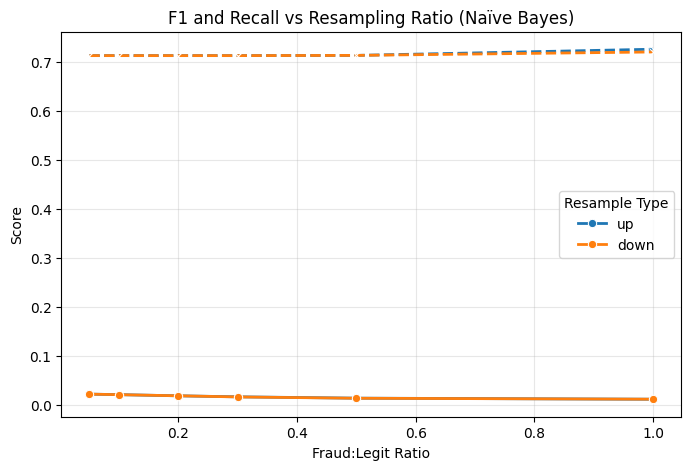


--- Mean Scores Summary ---
                     precision  recall     f1
ratio resample_type                          
0.05  down               0.011   0.713  0.022
      up                 0.011   0.713  0.022
0.10  down               0.011   0.713  0.021
      up                 0.011   0.713  0.021
0.20  down               0.010   0.713  0.019
      up                 0.010   0.713  0.019
0.30  down               0.008   0.713  0.017
      up                 0.009   0.713  0.017
0.50  down               0.007   0.714  0.014
      up                 0.007   0.714  0.014
1.00  down               0.006   0.721  0.012
      up                 0.006   0.726  0.012

Plots and summary complete.


In [16]:
print("\nGenerating plots...")

plt.figure(figsize=(8,5))
sns.lineplot(data=results_df, x="ratio", y="f1", hue="resample_type", marker="o", linewidth=2)
sns.lineplot(data=results_df, x="ratio", y="recall", hue="resample_type", marker="x", linestyle="--", linewidth=2, legend=False)
plt.title("F1 and Recall vs Resampling Ratio (Naïve Bayes)")
plt.xlabel("Fraud:Legit Ratio")
plt.ylabel("Score")
plt.grid(True, alpha=0.3)
plt.legend(title="Resample Type")
plt.savefig("results/naive_bayes_f1_recall_plot.png")
plt.show()


summary = results_df.groupby(["ratio", "resample_type"])[["precision", "recall", "f1"]].mean().round(3)
print("\n--- Mean Scores Summary ---")
print(summary)

print("\nPlots and summary complete.")